# Dataset: LC-level graph with PU

Now this gets interesting!

As we only have a single particle we care about, the decisions whether the given layercluster belongs to the reco trackster is binary.
This enables node-based prediction with simple labels.

In [1]:
import uproot
import numpy as np

import matplotlib.pyplot as plt

from reco.datasetPU import get_trackster_representative_points, get_tracksters_in_cone, get_major_PU_tracksters

ds_name = "CloseByGamma200PU"
file_name = "new_ntuples_15295178_20.root"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

file_path = f"{raw_dir}/{file_name}"

tracksters = uproot.open({file_path: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_path: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_path: "ticlNtuplizer/associations"})
graph = uproot.open({file_path: "ticlNtuplizer/graph"})

assoc_data = associations.arrays([
    "tsCLUE3D_recoToSim_SC",
    "tsCLUE3D_recoToSim_SC_sharedE",
    "tsCLUE3D_recoToSim_SC_score",
])

trackster_data = tracksters.arrays([
    "raw_energy",
    "barycenter_x",
    "barycenter_y",
    "barycenter_z",
    "vertices_x",
    "vertices_y",
    "vertices_z",
    "vertices_energy",
    "vertices_multiplicity",
    "vertices_indexes"
])

simtrackster_data = simtracksters.arrays([
    "stsSC_raw_energy"
])

In [6]:
eid = 0

vertices_x = trackster_data["vertices_x"][eid]
vertices_y = trackster_data["vertices_y"][eid]
vertices_z = trackster_data["vertices_z"][eid]
vertices_e = trackster_data["vertices_energy"][eid]
vertices_indices = trackster_data["vertices_indexes"][eid]

barycenter_x = trackster_data["barycenter_x"][eid]
barycenter_y = trackster_data["barycenter_y"][eid]
barycenter_z = trackster_data["barycenter_z"][eid]

reco2sim_index = assoc_data["tsCLUE3D_recoToSim_SC"][eid]
reco2sim_score = assoc_data["tsCLUE3D_recoToSim_SC_score"][eid]
reco2sim_sharedE = assoc_data["tsCLUE3D_recoToSim_SC_sharedE"][eid]

raw_energy = trackster_data["raw_energy"][eid]
sim_raw_energy = simtrackster_data["stsSC_raw_energy"][eid]

In [7]:
dataset = []

bigT = get_major_PU_tracksters(
    zip(reco2sim_index, reco2sim_sharedE, reco2sim_score),
    sim_raw_energy,
)

bigT = bigT[0]
min_z = min(vertices_z[bigT])
max_z = max(vertices_z[bigT])

barycentres = np.array((barycenter_x, barycenter_y, barycenter_z)).T

x1, x2 = get_trackster_representative_points(
    barycenter_x[bigT],
    barycenter_y[bigT], 
    barycenter_z[bigT],
    min_z,
    max_z
)

in_cone = get_tracksters_in_cone(x1, x2, barycentres, radius=10)

for recoTxId, distance in in_cone:
    if recoTxId == bigT:
        continue    # do not connect to itself

    label = 1 - reco2sim_score[recoTxId][0]
    dataset.append((recoTxId, distance, label))

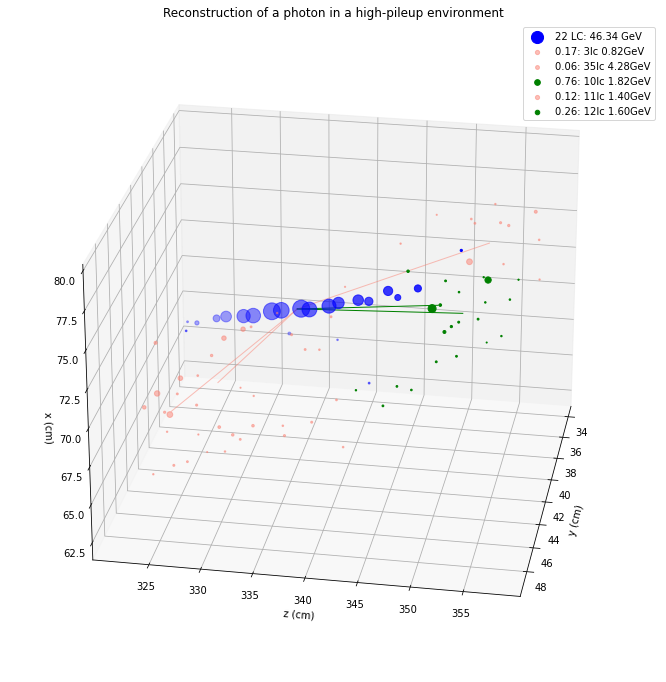

In [8]:
fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_title(f"Reconstruction of a photon in a high-pileup environment")
ax.set_xlabel("x (cm)")
ax.set_ylabel("y (cm)")
ax.set_zlabel("z (cm)")

bubble_size = 50
pileup_alpha = 0.5
noise_threshold = 0.2

def plot_edge(ax, edge, color, alpha=0.8):
    a, b = edge
    ca = barycentres[a]
    cb = barycentres[b]
    x = (ca[0], cb[0])
    y = (ca[1], cb[1])
    z = (ca[2], cb[2])
    ax.plot(x, y, z, c=color, linewidth=1, alpha=alpha)

bve = vertices_e[bigT]
ax.scatter(vertices_x[bigT], vertices_y[bigT], vertices_z[bigT], s=bve*bubble_size, c="blue", label=f"{len(bve)} LC: {sum(bve):.2f} GeV")

for recoTxId, distance, label in dataset:
    rve = vertices_e[recoTxId]
    rvb = raw_energy[recoTxId]
    clr = "green" if label > noise_threshold else "salmon"
    alpha = 1 if label > noise_threshold else pileup_alpha
    # ax.scatter(barycenter_x[recoTxId], barycenter_y[recoTxId], barycenter_z[recoTxId], s=rvb*bubble_size, c=clr, alpha=alpha, label=f"{label:.2f}: {len(rve)}lc {sum(rve):.2f}GeV")
    ax.scatter(vertices_x[recoTxId], vertices_y[recoTxId], vertices_z[recoTxId], s=rve*bubble_size, c=clr, label=f"{label:.2f}: {len(rve)}lc {sum(rve):.2f}GeV", alpha=alpha)
    plot_edge(ax, (bigT, recoTxId), clr, alpha=alpha)

ax.view_init(25, 10, "x")
plt.legend()
plt.show()

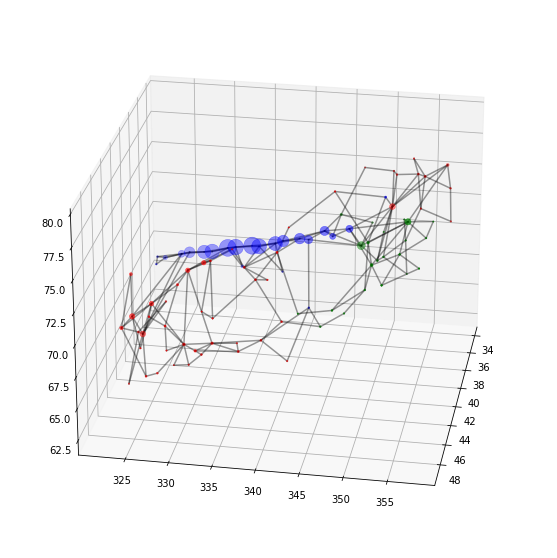

In [5]:
# build a graph (for fun!)
import awkward as ak
from reco.graphs import create_graph
from reco.plotting import plot_graph_3D

iter_src = [bigT] + list([x for x, _, _ in dataset])

color_labels_ = list([["green" if x > noise_threshold else "red"] * len(vertices_x[i]) for i, _, x in dataset])
color_labels = ak.flatten(color_labels_ + [["blue"] * len(vertices_x[bigT])])

tvx = ak.flatten(vertices_x[iter_src])
tvy = ak.flatten(vertices_y[iter_src])
tvz = ak.flatten(vertices_z[iter_src])
tve = ak.flatten(vertices_e[iter_src])
tvi = ak.flatten(vertices_indices[iter_src])

G = create_graph(tvx, tvy, tvz, tve, tvi, N=2, color=color_labels, higher_e=True)

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

plot_graph_3D(G, ax=ax, edges=True, s=bubble_size)
ax.view_init(25, 10, "x")